In [89]:
import re
import numpy as np
import pandas as pd
import os
from os import walk
import math

import cv2 as cv
import networkx as nx

import chart_studio.plotly as py
import plotly.offline as py
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from Shapes import shapes
from Lines import lines


### Pulling in Data

In [461]:
file_path = '/Users/agetecza/CAM_Data/AT_CAM/Data/Clean' #path to data on local computer

In [548]:
#Function to get unique elements from a list
def list_unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
            
    return unique_list

In [549]:
def make_id_list(my_file_path):

    #pull all filenames in your data directory
    _, _, filenames = next(walk(my_file_path))

    #grab only the id from the filenames to feed to the function
    id_list = []
    for filename in filenames:
        filename_split = filename.rsplit('_', 1)
        id_list.append(filename_split[0])
    
    unique_id = list_unique(id_list) #drop duplicate ids, since they are the same for _blocks & _links
        
    
    
    return unique_id

In [550]:
#Get an id_list from your specific file path
my_id_list = make_id_list(file_path)

In [551]:
#Look at total number of cams
len(my_id_list)

159

### Looking at a single CAM

In [552]:
cam_id = my_id_list[0] #grab a single id to just look through code

blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')

display(blocks)
display(links)

,id,title,x_pos,y_pos,width,height,shape,creator,num,comment,timestamp,modifiable,CAM
0,13570,Tax Discount,252.0,379.0,160.0,120.0,positive strong,709,3.0,NaN,17:59:35,1,817
1,13565,Revenue Netral,51.0,377.0,160.0,120.0,ambivalent,709,2.0,NaN,17:59:50,1,817
2,13577,Support Environment,323.0,20.0,160.0,120.0,positive strong,709,5.0,NaN,18:00:04,1,817
3,13562,Carbon Tax,238.0,123.0,160.0,120.0,neutral,709,1.0,NaN,17:52:37,1,817
4,13574,Green,44.0,20.0,160.0,120.0,positive strong,709,4.0,NaN,18:00:16,1,817
5,13582,Tax Oil Companies,541.0,306.0,160.0,120.0,positive strong,709,6.0,NaN,17:59:20,1,817
6,13588,Conservitive Dog Whistle,606.0,158.0,160.0,120.0,negative strong,709,8.0,NaN,17:59:12,1,817


,id,starting_block,ending_block,line_style,creator,num,arrow_type,timestamp,CAM
0,7785,13582,13588,Solid-Weak,709,0,none,17:57:08,817
1,7773,13562,13577,Solid-Weak,709,0,none,17:56:13,817
2,7765,13562,13570,Solid-Weak,709,0,none,17:55:28,817
3,7776,13562,13574,Solid-Weak,709,0,none,17:56:23,817
4,7753,13565,13570,Solid,709,0,none,17:54:56,817
5,7763,13562,13565,Solid,709,0,none,17:55:21,817
6,7782,13562,13582,Solid-Weak,709,0,none,17:56:56,817
7,7778,13562,13588,Solid-Weak,709,0,none,17:56:28,817
8,7787,13574,13577,Solid-Strong,709,0,none,17:57:26,817
9,7834,13570,13582,Dashed,709,0,none,18:00:43,817


## Create A Graph Using Networkx

### Create a function to build most basic graph

In [553]:
def graph_from_df(node_df, edge_df):
    # Get nodes
    nodes = node_df['id'].to_list()
    
    # Get edges
    edge_start = edge_df['starting_block'].to_list()
    edge_end = edge_df['ending_block'].to_list()
    edges = tuple(zip(edge_start, edge_end))
    
    # Create Graph
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G

In [554]:
G = graph_from_df(blocks,links)

### Create a function to add attributes 

In [555]:
def add_node_attributes(graph_name, node_df, attr_name): #attr_column_name must be in quotes
    
    blocks_dict = node_df[['id', attr_name]].set_index('id').to_dict()[attr_name]
    
    nx.set_node_attributes(graph_name, blocks_dict, attr_name)
    

In [556]:
def add_link_attributes(graph_name, edge_df, attr_name):
    attr_full_dict = {}
    
    edge_df['unique_link']= list(zip(edge_df['starting_block'], edge_df['ending_block']))
        
    for idx, row in edge_df.iterrows():
        
        attr_dict = {attr_name: row[attr_name]}
        
        attr_full_dict.update({row['unique_link']:attr_dict})
    
    nx.set_edge_attributes(G, attr_full_dict)
    
    
    

### Make all the Graphs
#### Store all graphs with attributes in a list

In [608]:
graph_list = []
working_id = []
no_data = []
missing_cam = []

for i in my_id_list:
    
    
    try:
        blocks_df = pd.read_csv(f'{file_path}/{i}_blocks.csv')

        links_df = pd.read_csv(f'{file_path}/{i}_links.csv')
        
        if len(links_df)>0:

            G = graph_from_df(blocks_df, links_df)

            add_node_attributes(G,blocks_df,'title')

            add_node_attributes(G,blocks_df,'shape')

            add_link_attributes(G, links_df, 'line_style')

            graph_list.append(G)
            
            working_id.append(i)

        
        else:
            no_data.append(i)
    
    except:
        
        missing_cam.append(i)
        print(f'CAM {i} does not exist')

print('Summary Info:')
print(f'number of missing cams: {len(missing_cam)}')
print(f'number of cams with no links: {len(no_data)}')
print(f'number of complete cams: {len(working_id)}')


CAM 575ec4be3fc3ac000611df4c__771 does not exist
Summary Info
number of missing cams: 1
number of cams with no links: 32
number of complete cams: 126


#### Look at one of the graphs stored in your graph list

[(13488, 13519, {'line_style': 'Solid-Strong'}), (13488, 13480, {'line_style': 'Dashed'}), (13480, 13510, {'line_style': 'Solid-Weak'}), (13480, 13485, {'line_style': 'Solid-Weak'}), (13480, 13519, {'line_style': 'Solid'}), (13480, 13537, {'line_style': 'Solid-Strong'}), (13480, 13545, {'line_style': 'Solid-Weak'}), (13480, 13558, {'line_style': 'Solid-Weak'}), (13485, 13510, {'line_style': 'Solid-Strong'}), (13485, 13558, {'line_style': 'Solid'}), (13545, 13537, {'line_style': 'Solid-Strong'})]
-------------------------
[(13488, {'title': 'Backlash from scary conservatives', 'shape': 'negative weak'}), (13480, {'title': 'Carbon Tax', 'shape': 'neutral'}), (13485, {'title': 'makes people more enviromentally concious', 'shape': 'positive weak'}), (13510, {'title': 'Fresher air', 'shape': 'positive strong'}), (13519, {'title': 'Price of goods could go up', 'shape': 'negative weak'}), (13545, {'title': 'More social service/ environment jobs', 'shape': 'positive weak'}), (13537, {'title': 

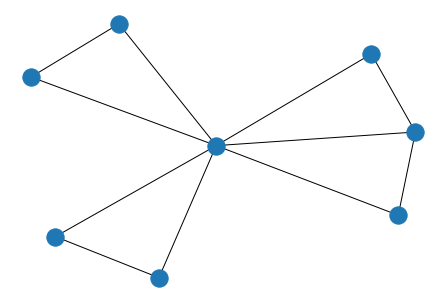

In [606]:
my_graph = graph_list[1]

nx.draw(my_graph)
print(my_graph.edges(data = True))
print('-------------------------')
print(my_graph.nodes(data = True))


# Simulations

### assumption: graph probability distribution is uniform, conditioned on size and density
 (all graphs of given size and density are equally probable)

G n,M = graph of size n, with M links 
Sample procedure:
create an empty graph with n vertices and randomly insert M links from n(n-1) possible links without replacement

### Function to make data frame of GLI for all CAMs

#### Note: I did not remove cams without nodes or edges, we should consider doing this

In [696]:
def calc_CAM_GLI(id_list):
    
    dictionary_list = []
    
    for cam_id in id_list:
        
        try:
            df_blocks = pd.read_csv(f'{file_path}/{cam_id}_blocks.csv')
            df_links = pd.read_csv(f'{file_path}/{cam_id}_links.csv')
        

            # Get nodes
            nodes = df_blocks['id'].to_list()
            
            # Get edges
            edge_start = df_links['starting_block'].to_list()
            edge_end = df_links['ending_block'].to_list()
            edges = tuple(zip(edge_start, edge_end))
            
            # Create Graph
            G = nx.Graph()
            G.add_nodes_from(nodes)
            G.add_edges_from(edges)
            
            # Calculate Density
            density = np.round(nx.density(G), 3)
            node_count = G.number_of_nodes()
            edge_count = G.size()
            
            # Calculate longest path
            try:
                components = nx.connected_components(G)
                largest_component = max(components, key=len)
                subgraph = G.subgraph(largest_component)
                diameter = nx.diameter(subgraph)
            except:
                diameter = 0
            # Calculate transitivity
            triadic_closure = np.round(nx.transitivity(G), 3)
            
            # Calculate max degree
            try:
                degree_centrality = nx.degree_centrality(G)
                max_centrality_ind = np.argmax(list(degree_centrality.values()))
                central_node = list(degree_centrality.keys())[max_centrality_ind]
                central_node_title = df_blocks[df_blocks['id'] == central_node]['title'].values[0]
                central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
            except:
                central_node = 0
                central_node_title = ''
                central_node_val = 0
                
            # Eigenvector Centrality
            try:
                eigenvector_centrality = nx.eigenvector_centrality(G)
                max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
                central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_eig = 0
                
            # Betweeness Centrality
            try:
                betweenness_centrality = nx.betweenness_centrality(G)
                max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
                central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
            except:
                central_node_val_bet = 0

            # Make the dictionary
            density_dict = {
                'cam_id': cam_id,
                'node_count': node_count,
                'edge_count': edge_count,
                'density': density,
                'diameter': diameter,
                'triadic_closure': triadic_closure,
                'central_node': central_node,
                'central_node_title': central_node_title,
                'central_node_val': central_node_val,
                'central_node_val_eig': central_node_val_eig,
                'central_node_val_bet': central_node_val_bet
            }

            dictionary_list.append(density_dict)
            
        except:
            print(f'No file found for {cam_id}')
        
    cam_density_df = pd.DataFrame(dictionary_list)
            
    return cam_density_df

In [697]:
cam_GLI_df = calc_CAM_GLI(my_id_list)
display(cam_GLI_df)

No file found for 575ec4be3fc3ac000611df4c__771


,cam_id,node_count,edge_count,density,diameter,triadic_closure,central_node,central_node_title,central_node_val,central_node_val_eig,central_node_val_bet
0,5f32a496a026e809d7d55cbd_817,7,10,0.476,2,0.480,13562,Carbon Tax,1.000,0.595,0.667
1,5f67f8d55e7718150fd23bc7_802,8,11,0.393,2,0.400,13480,Carbon Tax,1.000,0.623,0.786
2,5e45dd10f354ca0c7f4225c7_903,10,9,0.200,5,0.000,14076,economic growth,0.444,0.566,0.722
3,5f4ae6a7ad7baa6aecef4234_990,14,13,0.143,7,0.000,14686,Unequal effect on classes and regions,0.231,0.471,0.667
4,5a4e8f4930adf7000106fd5e_928,12,12,0.182,6,0.000,14279,Financial Burden,0.364,0.470,0.636
...,...,...,...,...,...,...,...,...,...,...,...
153,5f57fef7e7b06a35296f215d_822,12,17,0.258,5,0.214,13629,Economy,0.455,0.467,0.544
154,5b0f33dd1e55760001b9a9ce_812,11,22,0.400,3,0.495,13542,Carbon Tax,0.800,0.470,0.369
155,5ca6c9f3a752220001ca1be3_838,9,6,0.167,3,0.333,13693,Carbon Tax,0.500,0.628,0.286
156,5f7dd740074da20008c51bf5_818,7,8,0.381,4,0.400,13566,Carbon Tax,0.667,0.552,0.567


In [631]:
#get a df of the number of cams per node count
node_count_df = pd.DataFrame(cam_GLI_df.groupby('node_count',as_index=False).count()[['node_count','edge_count']]).rename(columns={'edge_count':'cam_count'})
node_count_df.head(5)

,node_count,cam_count
0,0,24
1,1,4
2,2,2
3,3,5
4,4,4


#### Note:
There are 24 cams that have no nodes. Do we want to include these?

Text(0.5, 1.0, 'Distribution of Node Count')

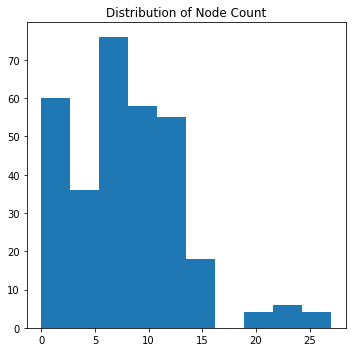

In [643]:
fig, axs = plt.subplots(figsize=(5,5),sharey=True, tight_layout=True)

# We can set the number of bins with the `bins` kwarg
axs.hist(cam_density_df['node_count'])
axs.set_title('Distribution of Node Count')


### Compare GLI from CAM with what would be expected from chance

### Anderson et al. Approach

In [676]:
col_list = list(cam_GLI_df.columns)
GLI_list = col_list[8:]
GLI_list

['central_node_val', 'central_node_val_eig', 'central_node_val_bet']

In [708]:
print(len(cam_GLI_df))

158


In [713]:
GLI_name = GLI_list[1]

P_H = 0
P_L = 0
N = 0 
N_max = 20 #number of iterations

alpha = .05 # desired level of significance
sig_cam_list = []

for i in range(len(cam_GLI_df)):
    Obs_GLI = cam_GLI_df[GLI_name][i] #observed GLI from row i

    n = cam_GLI_df['node_count'][i] # number of nodes for cam i
    m = cam_GLI_df['edge_count'][i]  # number of edges for cam i

    while N < N_max:

        # STEP 2: Make the random graph
        G_uni = nx.gnm_random_graph(n, m)


        #Get the necessary GLI measures
        # Calculate Density
        density = np.round(nx.density(G_uni), 3)

        # Calculate longest path
        try:
            components = nx.connected_components(G_uni)
            largest_component = max(components, key=len)
            subgraph = G_uni.subgraph(largest_component)
            diameter = nx.diameter(subgraph)
        except:
            diameter = 0
        # Calculate transitivity
        triadic_closure = np.round(nx.transitivity(G_uni), 3)

        # Calculate max degree
        try:
            degree_centrality = nx.degree_centrality(G_uni)
            max_centrality_ind = np.argmax(list(degree_centrality.values()))
            central_node_val = np.round(list(degree_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val = 0

        # Eigenvector Centrality
        try:
            eigenvector_centrality = nx.eigenvector_centrality(G_uni)
            max_centrality_ind = np.argmax(list(eigenvector_centrality.values()))
            central_node_val_eig = np.round(list(eigenvector_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_eig = 0

        # Betweeness Centrality
        try:
            betweenness_centrality = nx.betweenness_centrality(G_uni)
            max_centrality_ind = np.argmax(list(betweenness_centrality.values()))
            central_node_val_bet = np.round(list(betweenness_centrality.values())[max_centrality_ind], 3)
        except:
            central_node_val_bet = 0

        # Make the dictionary
        G_uni_GLI_dict = {
            'central_node_val': central_node_val,
            'central_node_val_eig': central_node_val_eig,
            'central_node_val_bet': central_node_val_bet
        }

        #STEP 3 - #Maybe issue with have a two conditions with the 'equal to' option
        
        if G_uni_GLI_dict[GLI_name] >= Obs_GLI:
            P_H = P_H + 1

        elif G_uni_GLI_dict[GLI_name] <= Obs_GLI:
            P_L = P_L +1

        #increment N for each iteration till max is reached
        N = N + 1

    #Step 5
    condition_1 = (P_H/N_max) < (alpha/2)
    condition_2 = (P_L/N_max) < (alpha/2)

    if condition_1 | condition_2:
        
        sig_cam_list.append(cam_GLI_df['cam_id'][i])

In [714]:
len(sig_cam_list)

158

## Add Survey Info to CAM data

In [720]:
file_path_survey = '/Users/agetecza/CAM_Data/AT_CAM/Data/CAM_Survey_Merged.csv'
survey_df = pd.read_csv(file_path_survey)
survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,WilsonPat_5,WilsonPat_6,WilsonPat_7,WilsonPat_8,WilsonPat_9,WilsonPat_10,WilsonPat_11,WilsonPat_12,CheckNum,mTurkCode2
0,2021-01-11 11:46,2021-01-11 11:46,0,50.69.196.183,100,8,1,2021-01-11 11:46,R_2ZQySv7eilk1BhL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-01-11 11:48,2021-01-11 11:59,0,50.69.196.183,100,660,1,2021-01-11 11:59,R_8erRxEBvfzDsLGp,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-11 11:51,2021-01-11 12:01,0,69.158.246.27,100,635,1,2021-01-11 12:01,R_xgzbLgWncp56ACJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-01-11 12:01,2021-01-11 12:13,0,24.212.224.202,100,739,1,2021-01-11 12:13,R_3rOr7B1NkrQgen5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-01-11 12:04,2021-01-11 12:18,0,24.77.79.89,100,820,1,2021-01-11 12:18,R_1KdKzGSFXHqdKef,NaN,...,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,8165033.0


In [722]:
survey_column_list = list(survey_df.columns)
survey_column_list

['StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'Progress',
 'Duration (in seconds)',
 'Finished',
 'RecordedDate',
 'ResponseId',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'Screen1',
 'Consent2',
 'Prolific1',
 'Prolific2',
 'Time1_First Click',
 'Time1_Last Click',
 'Time1_Page Submit',
 'Time1_Click Count',
 'CarbFam',
 'CarbSFam',
 'CarbAg',
 'CarbDis',
 'CarbHear',
 'CarbTextD',
 'Interest_1',
 'CarbDecide',
 'TutorialConfirmation',
 'CAMCheck1',
 'CAMCheck2',
 'CAMCheck3',
 'CAMCheck4',
 'Complete',
 'TreatmentCheck',
 'Represent_1',
 'Stop',
 'mTurkCode',
 'Prolific2 - Parent Topics',
 'Prolific2 - Topics',
 'OneStageDrop',
 'Prolific1.1',
 'Prolific1.2',
 'StartDate.1',
 'EndDate.1',
 'Status.1',
 'IPAddress.1',
 'Progress.1',
 'Duration (in seconds).1',
 'Finished.1',
 'RecordedDate.1',
 'ResponseId.1',
 'RecipientLastName.1',
 'RecipientFirstNam